In [1]:
from utils.visualize_predictions import visualize_prediction
from utils.KittiRoadsDataset import KittiRoadsDataset
from torch.utils.data import DataLoader, random_split
from utils.UNetTorch import UNet
import torch.optim as optim
import torch.nn as nn
import torch


dataset = KittiRoadsDataset(
    root_dir="datasets/kitti_roads/training",
)

train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(
    dataset,
    [train_size, test_size]
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False
)

print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
sample = dataset[0]
print("Image shape:", sample["image"].shape)
print("Mask shape:", sample["road_gt"].shape)
print("Unique mask values:", torch.unique(sample["road_gt"]))

Train size: 230, Test size: 26
Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Unique mask values: tensor([0, 1, 2])


In [2]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else "mps"
)

model = UNet(
    in_channels=3,
    out_channels=3
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3
)

Saved new best model ✅
Epoch [1/200], Loss: 0.6542
Saved new best model ✅
Epoch [2/200], Loss: 0.4505
Saved new best model ✅
Epoch [3/200], Loss: 0.4459
Saved new best model ✅
Epoch [4/200], Loss: 0.4434
Saved new best model ✅
Epoch [5/200], Loss: 0.4139
Saved new best model ✅
Epoch [6/200], Loss: 0.4014
Epoch [7/200], Loss: 0.4026
Saved new best model ✅
Epoch [8/200], Loss: 0.3952
Saved new best model ✅
Epoch [9/200], Loss: 0.3944
Epoch [10/200], Loss: 0.4327
Saved new best model ✅
Epoch [11/200], Loss: 0.3861
Saved new best model ✅
Epoch [12/200], Loss: 0.3654
Saved new best model ✅
Epoch [13/200], Loss: 0.3359
Saved new best model ✅
Epoch [14/200], Loss: 0.3336
Saved new best model ✅
Epoch [15/200], Loss: 0.3271
Saved new best model ✅
Epoch [16/200], Loss: 0.3140
Saved new best model ✅
Epoch [17/200], Loss: 0.3040
Saved new best model ✅
Epoch [18/200], Loss: 0.2919
Epoch [19/200], Loss: 0.2937
Saved new best model ✅
Epoch [20/200], Loss: 0.2845
Epoch [21/200], Loss: 0.2942
Epoch [22

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.52156866].


Epoch [200/200], Loss: 0.1727


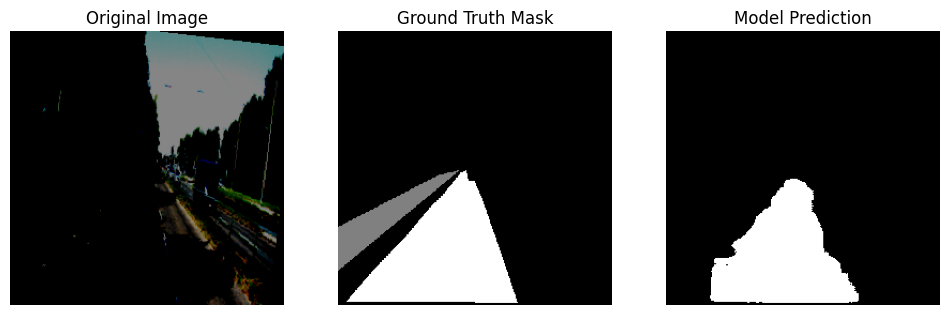

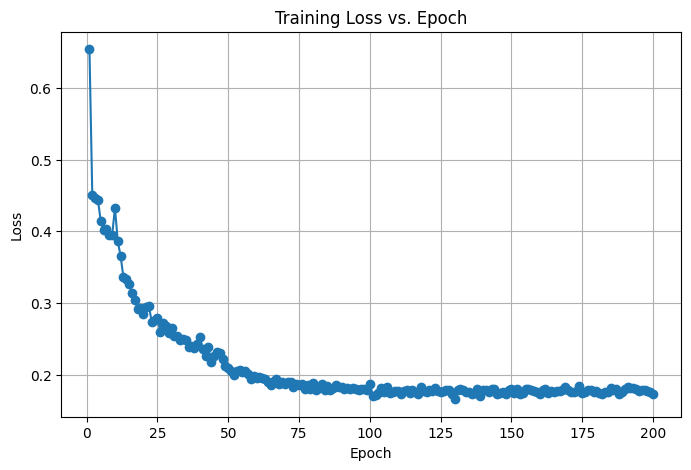

Training complete!


In [3]:
import matplotlib.pyplot as plt

best_loss = float("inf")
num_epochs = 200
loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        images = batch['image'].to(device)
        masks = batch['road_gt'].to(device).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, "best_unet_model_3.pth")
        print("Saved new best model ✅")

    scheduler.step(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.4f}")

visualize_prediction(
    model,
    dataset,
    idx=5,
    device=device
)

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), loss_history, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epoch")
plt.grid()
plt.savefig('myimage.svg', format='svg', dpi=1200)
plt.show()

print("Training complete!")